# Checking results of `State-evolution` with my own propagation method

In [1]:
from utils.fields import *
from utils.trajectories import *
from utils.hamiltonianoperators import *
from utils.quantumoperators import *
from scipy.linalg import expm

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

In [3]:
%%time

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ6 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 58.1 s


## Running the first 5 trajectories of *_545.mat

Contain trajectories calculated by Oskari to reach the end of the lens

In [4]:
from trajectories import *
positions = load_trajectories('trajectories/positions_545.mat')
velocities = load_velocities('trajectories/velocities_545.mat')

t, (xT, yT, zT), (xVelocity, yVelocity, zVelocity) = get_time_position_velocity(positions, velocities)

In [5]:
interpolateTrajectories = []
for idInt in range(t.shape[1]):
    interpolateTrajectories.append((make_interpolate(t[:,idInt], xT[:,idInt], yT[:,idInt], zT[:,idInt])))

In [6]:
from utils.fields import *
c, intfun = fit_potential_xyz("D:/Adiabatic Transfer/propagation/fields/"+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)

cP, intfunP = fit_potential_xyz("D:/Adiabatic Transfer/propagation/fields/"+'potentialElectrodes.fld', 0.022, 0.019, .45, 0)

funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

C:\Users\Olivier\Documents\Drive\CeNTREX Olivier\notebooks\non-adiabatic transitions\propagation\cluster simulations\convergence test State-evolution\utils\fields.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


In [7]:
from tqdm import tqdm_notebook as tqdm

def run_evolution(ham, trajectories, field, level, dt = (5e-7, 1e-6)):
    probabilities = []
    
    for traj in tqdm(trajectories):
        coords = lambda t: np.array([traj[0](t), traj[1](t), traj[2](t)])
        
        ti = 0
        phi = np.linalg.eigh(ham(*field(*coords(ti))))[1][:,level]
        ti += dt[0]
        while ti <= traj[-1]:
            xi,yi,zi = coords(ti)
            if (-0.36 < zi < -0.26) or (0.26 < zi < 0.36):
                dti = dt[0]
            else:
                dti = dt[1]
            phi = expm(-1j*2*np.pi*ham(*field(*coords(ti)))*dti)@phi
            ti += dti
        phif = np.linalg.eigh(ham(*field(*coords(ti-dti))))[1][:,level]
        probabilities.append(np.abs(phif.conj()@phi)**2)
    return probabilities



Wall time: 15min 31s


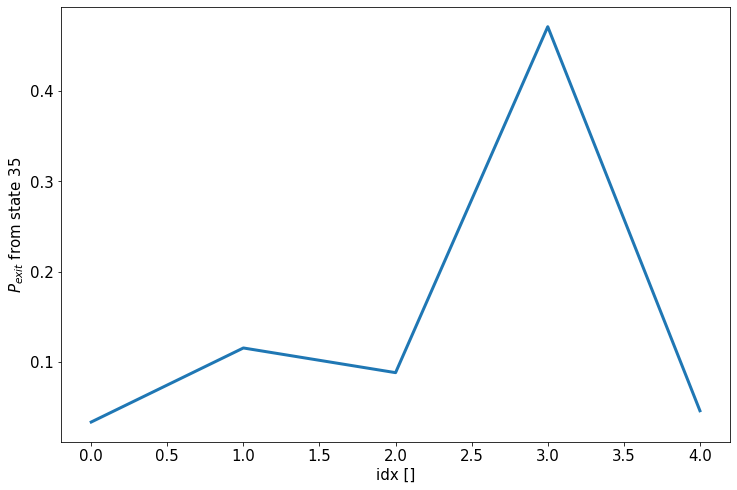

In [8]:
%%time 

fields = lambda x,y,z: np.array([funEz(x,y,z), funEx(x,y,z), funEy(x,y,z), 0, 0, 0.5])
probs = run_evolution(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[:5], fields, 35)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(1 - np.array(probs), lw = 3)
ax.set_xlabel('idx []')
ax.set_ylabel(r'$P_{exit}$ from state 35')
set_fontsize(ax, 15)

## Change orientation to have major field in y (my original convention) for comparison

Verify orientation change does not have any effect on the outcome

Wall time: 14min 7s


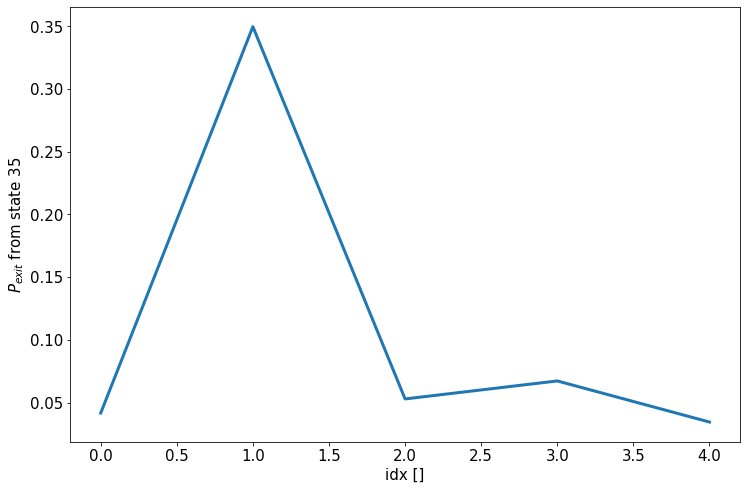

In [18]:
%%time 

fields = lambda x,y,z: np.array([funEx(x,y,z), funEy(x,y,z), funEz(x,y,z), 0, 0, 0.5])
probs = run_evolution(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[:5], fields, 35)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(1 - np.array(probs), lw = 3)
ax.set_xlabel('idx []')
ax.set_ylabel(r'$P_{exit}$ from state 35')
set_fontsize(ax, 15)

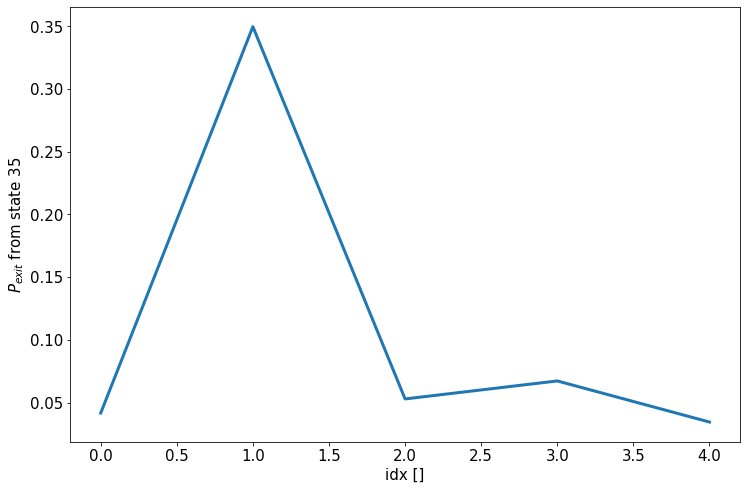

In [19]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(1 - np.array(probs), lw = 3)
ax.set_xlabel('idx []')
ax.set_ylabel(r'$P_{exit}$ from state 35')
set_fontsize(ax, 15)

## Using the json dict as defined in `full_trajectories.json`

To ensure the field definition given to `State-evolution` does not result in a different outcome

In [20]:
json_dict = {
  "H_fname"       : "matrices/H6.npy",
  "field_str": [
     "A*(potential_plate_z.derivative()(trajectories[idx][2](t))*np.polynomial.polynomial.polyval2d(trajectories[idx][0](t),trajectories[idx][1](t),potential_plate_xy[0]))/100 + potential_quadrupole_z.derivative()(trajectories[idx][2](t))*np.polynomial.polynomial.polyval2d(trajectories[idx][0](t),trajectories[idx][1](t),potential_quadrupole_xy[0])/100",
     "A*(potential_plate_z(trajectories[idx][2](t))*np.polynomial.polynomial.polyval2d(trajectories[idx][0](t),trajectories[idx][1](t),potential_plate_xy[1]))/100 + potential_quadrupole_z(trajectories[idx][2](t))*np.polynomial.polynomial.polyval2d(trajectories[idx][0](t),trajectories[idx][1](t),potential_quadrupole_xy[1])/100",
     "A*(potential_plate_z(trajectories[idx][2](t))*np.polynomial.polynomial.polyval2d(trajectories[idx][0](t),trajectories[idx][1](t),potential_plate_xy[2]))/100 + potential_quadrupole_z(trajectories[idx][2](t))*np.polynomial.polynomial.polyval2d(trajectories[idx][0](t),trajectories[idx][1](t),potential_quadrupole_xy[2])/100",
     "0*t",
     "0*t",
     "0*t + 0.5"
  ],
  "scan_param"    : "idx",
  "scan_range": {
    "start"       : 0,
    "stop"        : 4,
    "num"         : 5,
    "dtype"       : "int"
  },
  "fixed_params": {
    "A"           : 1
  },
  "pickle_fnames": {
     "potential_plate_xy"       : "runs State-evolution/options/potential_plate_xy_run1.pkl",
     "potential_plate_z"        : "runs State-evolution/options/potential_plate_z_run1.pkl",
     "potential_quadrupole_xy"  : "runs State-evolution/options/potential_quadrupole_xy_run1.pkl",
     "potential_quadrupole_z"   : "runs State-evolution/options/potential_quadrupole_z_run1.pkl",
     "trajectories"             : "runs State-evolution/options/trajectories_run1.pkl"
  },
  "units": {
    "A"         : "V/cm",
    "idx"         : ""
  },
  "time_params": {
    "num_segm"    : "100",
    "t_final"     : "trajectories[idx][-1]",
    "segm_pts"    : "100 if ((-0.36 < trajectories[idx][2](T0) < -0.25) or (0.25 < trajectories[idx][2](T0) < 0.36)) else 50",
    "batch_size"  : 1
  },
  "state_idx"     : 35,
  "s"             : 15
}


In [29]:
import pickle

def eval_num(expr, scope):
    return eval(expr, {**scope, 'np':np})

def run_evolution_json(ham, json, dt = (5e-7, 1e-6)):
    
    pickled_vars = {}
    for key, fname in json_dict['pickle_fnames'].items():
        with open(fname, 'rb') as f:
            pickled_vars[key] = pickle.load(f)
    
    level = json['state_idx']
    
    probabilities = []
    
    for idx in tqdm(np.linspace(**json['scan_range'])):
        traj = pickled_vars['trajectories'][idx]
        coords = lambda t: (traj[0](t), traj[1](t), traj[2](t))
        field = lambda t: np.transpose([eval_num(x,{'A':1, 'idx':idx, **pickled_vars,'t':t}) for x in json_dict['field_str']])
        
        ti = 0
        phi = np.linalg.eigh(ham(*field(ti)))[1][:,level]
        ti += dt[0]
        while ti <= traj[-1]:
            xi,yi,zi = coords(ti)
            if (-0.36 < zi < -0.26) or (0.26 < zi < 0.36):
                dti = dt[0]
            else:
                dti = dt[1]
            phi = expm(-1j*2*np.pi*ham(*field(ti))*dti)@phi
            ti += dti
        phif = np.linalg.eigh(ham(*field(ti-dti)))[1][:,level]
        probabilities.append(np.abs(phif.conj()@phi)**2)
    return probabilities

Wall time: 13min 9s


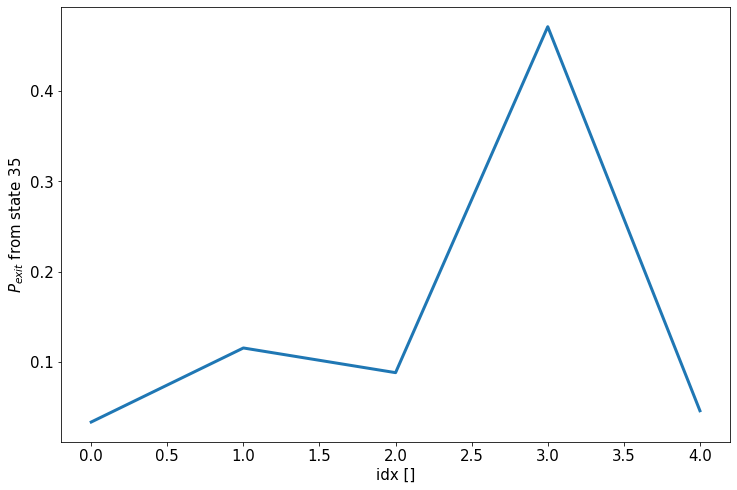

In [30]:
%%time
probs = run_evolution_json(HamiltonianJ6.create_hamiltonian, json_dict)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(1 - np.array(probs), lw = 3)
ax.set_xlabel('idx []')
ax.set_ylabel(r'$P_{exit}$ from state 35')
set_fontsize(ax, 15)

### Result from `State-evolution` converges

<img src = "runs State-evolution/plots/full_trajectories-aaffdfcb44a746ed4390059212d93135.png" style = "float: left;">

## Simple test model, propagating through a sine electric field $1000\sin\left(2\pi \frac{1}{t_{max}}t\right)+500$ in 0.5G

In [31]:
from tqdm import tqdm_notebook as tqdm

def run_evolution_sine(ham, trajectories, level, dt = (5e-7, 1e-6)):
    probabilities = []
    
    for traj in tqdm(trajectories):
        coords = lambda t: np.array([traj[0](t), traj[1](t), traj[2](t)])
        field = lambda t: (0*t,0*t,1000*np.sin(2*np.pi*1/(traj[-1])*t)+500, 0, 0, 0.5)
        
        ti = 0
        phi = np.linalg.eigh(ham(*field(ti)))[1][:,level]
        ti += dt[0]
        while ti <= traj[-1]:
            xi,yi,zi = coords(ti)
            if (-0.36 < zi < -0.26) or (0.26 < zi < 0.36):
                dti = dt[0]
            else:
                dti = dt[1]
            phi = expm(-1j*2*np.pi*ham(*field(ti))*dti)@phi
            ti += dti
        phif = np.linalg.eigh(ham(*field(ti-dti)))[1][:,level]
        probabilities.append(np.abs(phif.conj()@phi)**2)
    return probabilities


Wall time: 12min 11s


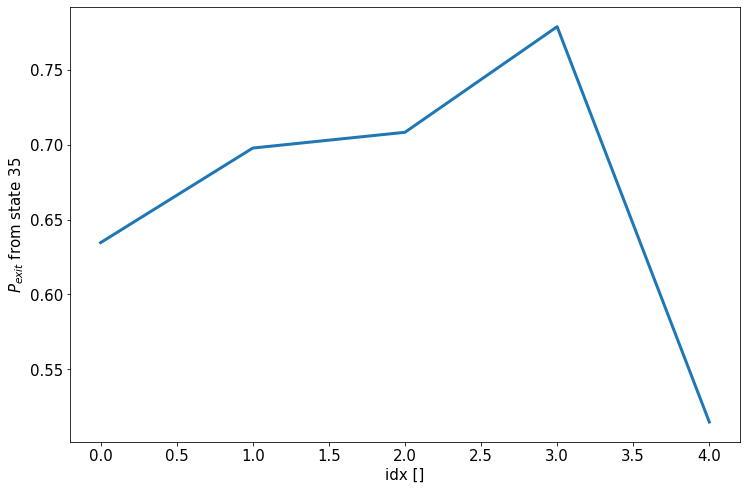

In [32]:
%%time 

probs = run_evolution_sine(HamiltonianJ6.create_hamiltonian, interpolateTrajectories[:5], 35)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(1 - np.array(probs), lw = 3)
ax.set_xlabel('idx []')
ax.set_ylabel(r'$P_{exit}$ from state 35')
set_fontsize(ax, 15)

### Result from `State-evolution` converges
<img src = "runs State-evolution/plots/sine_field-c8040abcd5ca1539010196a30977ac7c.png" style = "float: left;">

## More simplified field, $A\sin\left(2\pi \frac{1}{0.0004}t\right)+500$ in 0.5G

In [33]:
from tqdm import tqdm_notebook as tqdm

def run_evolution_sine_simple(ham, A_list, level):
    probabilities = []
    
    
    t = np.linspace(0, 0.0004, 750)
    dt = np.diff(t)[0]
    
    for A in tqdm(A_list):
        field = lambda t: (0*t, 0*t, A*np.sin(2*np.pi*(1/0.0004)*t)+500, 0, 0, 0*t+0.5)
        phi = np.linalg.eigh(ham(*field(0)))[1][:,level]
        for ti in t:
                phi = expm(-1j*2*np.pi*ham(*field(ti))*dt)@phi
        phif = np.linalg.eigh(ham(*field(t[-1])))[1][:,level]
        probabilities.append(np.abs(phif.conj()@phi)**2)
    return probabilities

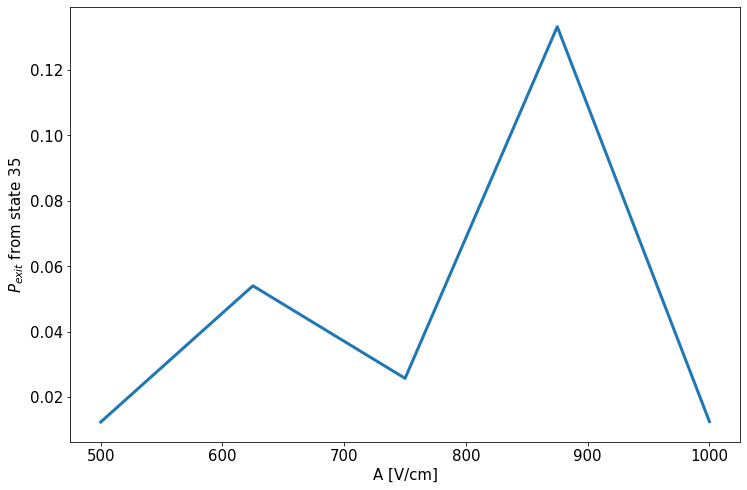

In [34]:
probs = run_evolution_sine_simple(HamiltonianJ6.create_hamiltonian, np.linspace(500, 1000, 5), 35)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(np.linspace(500, 1000, 5), 1 - np.array(probs), lw = 3)
ax.set_xlabel('A [V/cm]')
ax.set_ylabel(r'$P_{exit}$ from state 35')
set_fontsize(ax, 15)

### Result from `State-evolution` converges, slight difference because my method evolves one more timestep
Method stops at t+dt instead of t as in State-evolution

<img src = "runs State-evolution/plots/sine_simple-380a83b1c285707c8fba7f193fa3dd04.png" style = "float: left;">

## Verifying first calculating all successive U and then evolving the states converges with evolving $\psi$ for each timestep

In [35]:
from functools import reduce

def run_evolution_U(ham, A_list):    
    t = np.linspace(0, 0.0004, 750)
    dt = np.diff(t)[0]
    U_list = []
    
    print(f'{len(t)*len(A_list)} steps')
    
    for A in tqdm(A_list):
        field = lambda t: (0*t, 0*t, A*np.sin(2*np.pi*(1/0.0004)*t)+500, 0*t, 0*t, 0*t+0.5)
        
        U = np.eye(ham(0,0,0,0,0,0).shape[-1])        
        
        for ti in t:
            U = expm(-1j*2*np.pi*dt * ham(*field(ti))) @ U
        U_list.append(U)
    return U_list

In [36]:
%%time
U = run_evolution_U(HamiltonianJ6.create_hamiltonian, np.linspace(500, 1000, 5))

3750 steps


Wall time: 1min 38s


## Checking difference between $\left<\psi_f|U|\psi_i\right>$, $\left<\psi_f|U|\psi_f\right>$ and $\left<\psi_i|U|\psi_i\right>$ 
Physical would be $\left<\psi_f|U|\psi_i\right>$, but some of my old code ran $\left<\psi_i|U|\psi_i\right>$ becasue the initial and final fields were identical

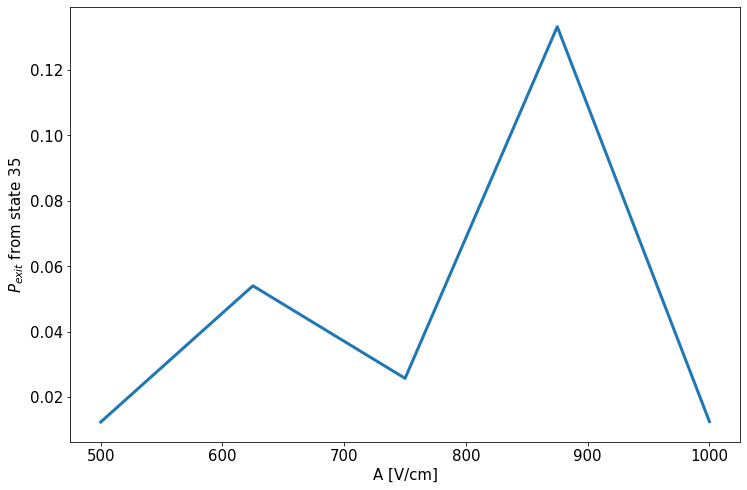

In [37]:
probs = []
for A,Ui in zip(np.linspace(500,1000,5),U):
    field = lambda t: (0*t, 0*t, A*np.sin(2*np.pi*(1/0.0004)*t)+500, 0, 0, 0+0.5)
    HI = HamiltonianJ6.create_hamiltonian(*field(0))
    phiI = np.linalg.eigh(HI)[1][:,35]
    HF = HamiltonianJ6.create_hamiltonian(*field(0.0004))
    phiF = np.linalg.eigh(HF)[1][:,35]
    probs.append(1-np.abs(phiF.conj()@Ui@phiI)**2)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(np.linspace(500, 1000, 5), probs, lw = 3)
ax.set_xlabel('A [V/cm]')
ax.set_ylabel(r'$P_{exit}$ from state 35')
set_fontsize(ax, 15)

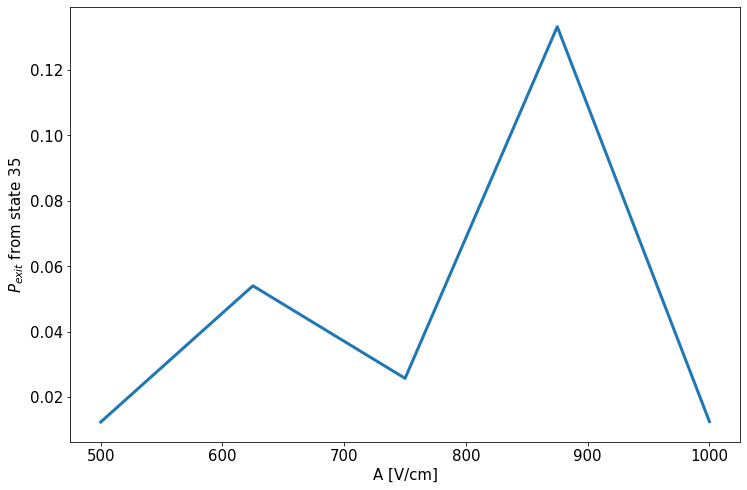

In [38]:
probs = []
for A,Ui in zip(np.linspace(500,1000,5),U):
    field = lambda t: (0*t, 0*t, A*np.sin(2*np.pi*(1/0.0004)*t)+500, 0, 0, 0*t+0.5)
    HI = HamiltonianJ6.create_hamiltonian(*field(0))
    phiI = np.linalg.eigh(HI)[1][:,35]
    HF = HamiltonianJ6.create_hamiltonian(*field(0.0004))
    phiF = np.linalg.eigh(HF)[1][:,35]
    probs.append(1-np.abs(phiF.conj()@Ui@phiF)**2)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(np.linspace(500, 1000, 5), probs, lw = 3)
ax.set_xlabel('A [V/cm]')
ax.set_ylabel(r'$P_{exit}$ from state 35')
set_fontsize(ax, 15)

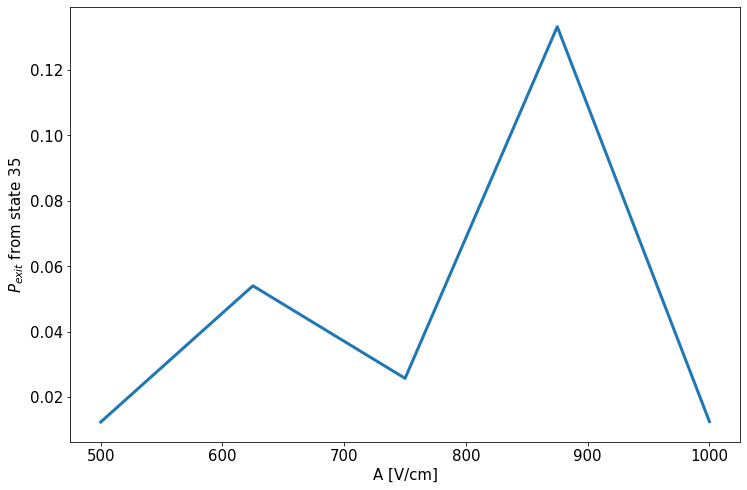

In [39]:
probs = []
for A,Ui in zip(np.linspace(500,1000,5),U):
    field = lambda t: (0*t, 0*t, A*np.sin(2*np.pi*(1/0.0004)*t)+500, 0, 0, 0*t+0.5)
    HI = HamiltonianJ6.create_hamiltonian(*field(0))
    phiI = np.linalg.eigh(HI)[1][:,35]
    HF = HamiltonianJ6.create_hamiltonian(*field(0.0004))
    phiF = np.linalg.eigh(HF)[1][:,35]
    probs.append(1-np.abs(phiI.conj()@Ui@phiI)**2)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(np.linspace(500, 1000, 5), probs, lw = 3)
ax.set_xlabel('A [V/cm]')
ax.set_ylabel(r'$P_{exit}$ from state 35')
set_fontsize(ax, 15)

Difference is negliglible because we end up in the same fields at the end of a run for these evolution calculations